<a href="https://colab.research.google.com/github/dvfriedheim/PredictiveModel-HumanActivityRecognition/blob/master/NN_vision_example_Flower_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 2s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


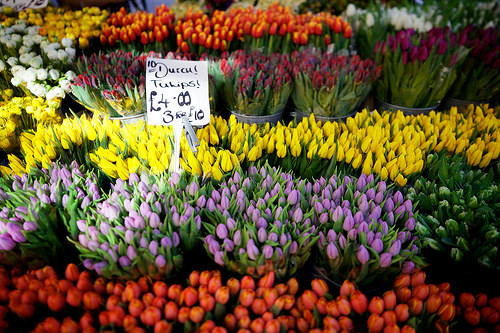

In [4]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


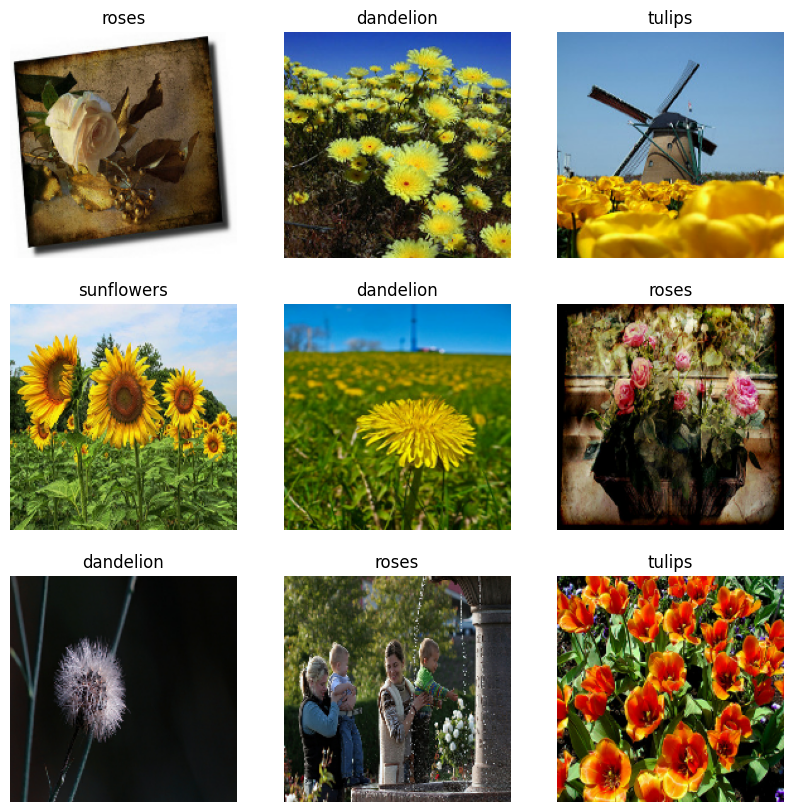

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.9918303


In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [15]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [17]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 112s 1s/step - loss: 1.3100 - accuracy: 0.4653 - val_loss: 1.0628 - val_accuracy: 0.5899
Epoch 2/10
92/92 [==============================] - 105s 1s/step - loss: 0.9534 - accuracy: 0.6345 - val_loss: 0.9950 - val_accuracy: 0.6172
Epoch 3/10
92/92 [==============================] - 107s 1s/step - loss: 0.7521 - accuracy: 0.7204 - val_loss: 0.9173 - val_accuracy: 0.6526
Epoch 4/10
92/92 [==============================] - 110s 1s/step - loss: 0.5474 - accuracy: 0.8007 - val_loss: 1.0061 - val_accuracy: 0.6390
Epoch 5/10
92/92 [==============================] - 107s 1s/step - loss: 0.3467 - accuracy: 0.8760 - val_loss: 1.0731 - val_accuracy: 0.6730
Epoch 6/10
92/92 [==============================] - 105s 1s/step - loss: 0.2012 - accuracy: 0.9326 - val_loss: 1.3776 - val_accuracy: 0.6444
Epoch 7/10
92/92 [==============================] - 110s 1s/step - loss: 0.1191 - accuracy: 0.9646 - val_loss: 1.3972 - val_accuracy: 0.6703
Epoch 8/10
92

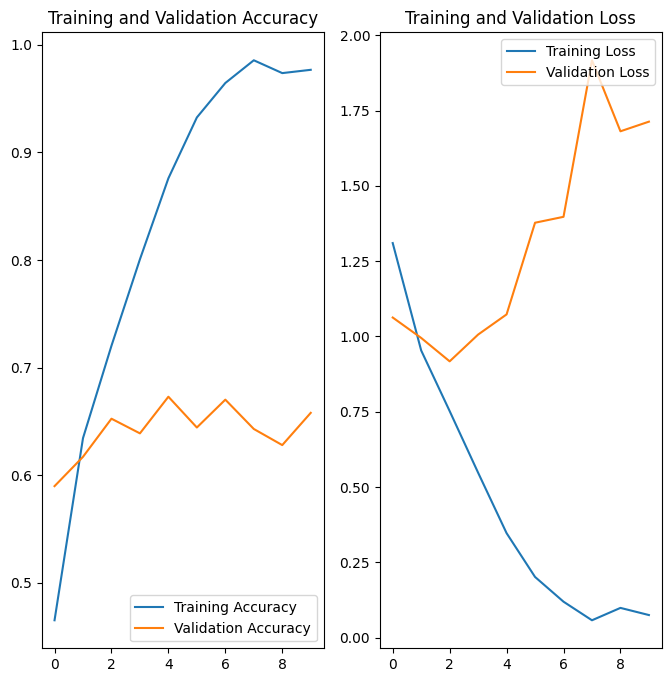

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
